# Settings

In [1]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [2]:
## Patch for annotations in R4.1
# BiocManager::install("Bioconductor/GenomeInfoDb",lib = "/home/luca/R/x86_64-pc-linux-gnu-library/4.1",force = TRUE)
# library(GenomeInfoDb,lib.loc="/home/luca/R/x86_64-pc-linux-gnu-library/4.1")

In [3]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix, future, 
               hdf5r, Seurat, Signac,harmony, knitr, SoupX, 
               EnsDb.Hsapiens.v86, 
               logr, parallel, 
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x)

In [4]:
# Load genome
#suppressMessages(annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86))
#genome(annotations) <- 'hg38'
#seqlevelsStyle(annotations) <- 'UCSC'
# Save table
# writeRDS(annotations, "/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")

# Load table
annotations = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- 'hg38'

# Seq info downloaded from: https://github.com/broadinstitute/ichorCNA/issues/84
seq.info = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/seqinfo_hg38_ucsc.rds")

In [5]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

# set Future
plan("multicore", workers = 4)
# set RAM treshold
## 1000 = 1gb
RAM.tresh = 10000 * 1024^2
options(future.globals.maxSize = RAM.tresh)
options(scipen = 999)

In [6]:
# Set directories
base.dir = "/nfs/lab/projects/mega_heart/"
assets.dir = "/nfs/lab/projects/mega_heart/Assets/"

reference.dir = "/nfs/lab/tscc/luca/MEGA_Heart/LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.peaks.rds"

In [7]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "Cell.markers_5.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]
# Factorize columns
cell.markers$Compartment = factor(cell.markers$Compartment, 
                        levels = c("Muscular", "Vascular", "Neuro", "Stromal", "Immune"))

cell.compartment = cell.markers[,-3]

In [8]:
cell.markers$CellType = factor(cell.markers$CellType,
                        levels = c("aCM", "vCM",                                   
                                   "SM", "Pericyte",
                                   "Endothelial","Endocardial", "Epicardial", 
                                   "Neuronal", "Fibroblast", "Adipocyte", 'Lymphoid', 'Myeloid'))

In [9]:
log_open(file_name = paste0(base.dir, "Metadata_label.log"))

[1] "/nfs/lab/projects/mega_heart/log/Metadata_label.log"

# UMAP plots

In [10]:
colors.use = c("cadetblue4", "salmon", "lightgoldenrod", 
    "paleturquoise3","palegreen3", "mediumpurple1", 
    "lightblue4", "navajowhite1", "magenta", "coral2", 
    "mediumorchid1", "midnightblue", "lightgoldenrodyellow", 
    "black", "lightgrey", "mistyrose4","darkcyan", "steelblue2", 
    "darkolivegreen3", "mediumpurple1", "lightskyblue", "firebrick2",
    "burlywood", "chartreuse1", "deeppink2", "khaki", "powderblue",
    "slategrey", "springgreen", "yellow3", "orange2", "lightsteelblue3", 
    "tomato3", "palegreen4", "grey27", "darkseagreen", "blue", "darkorchid",
    "snow2", "peachpuff2", "magenta2", "yellowgreen", "cornflowerblue",
    "chocolate", "blueviolet", "lighblue1", "plum2")

In [11]:
in.dir = reference.dir

In [12]:
log_print(" Loading data")
adata = readRDS(in.dir)
log_print(paste("Done"))

[1] " Loading data"
[1] "Done"


# Reformat metadata

In [31]:
# visualize the results for individual objects
gg1 = DimPlot(adata, reduction = 'joint.umap',
        group.by = 'cell.major_types', label=TRUE, repel=TRUE, order = FALSE) + NoLegend()

# visualize the results for individual objects
gg2 = DimPlot(adata, reduction = 'joint.umap',
        group.by = 'cell.sub_types', label=TRUE, repel=TRUE, order = FALSE) + NoLegend()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



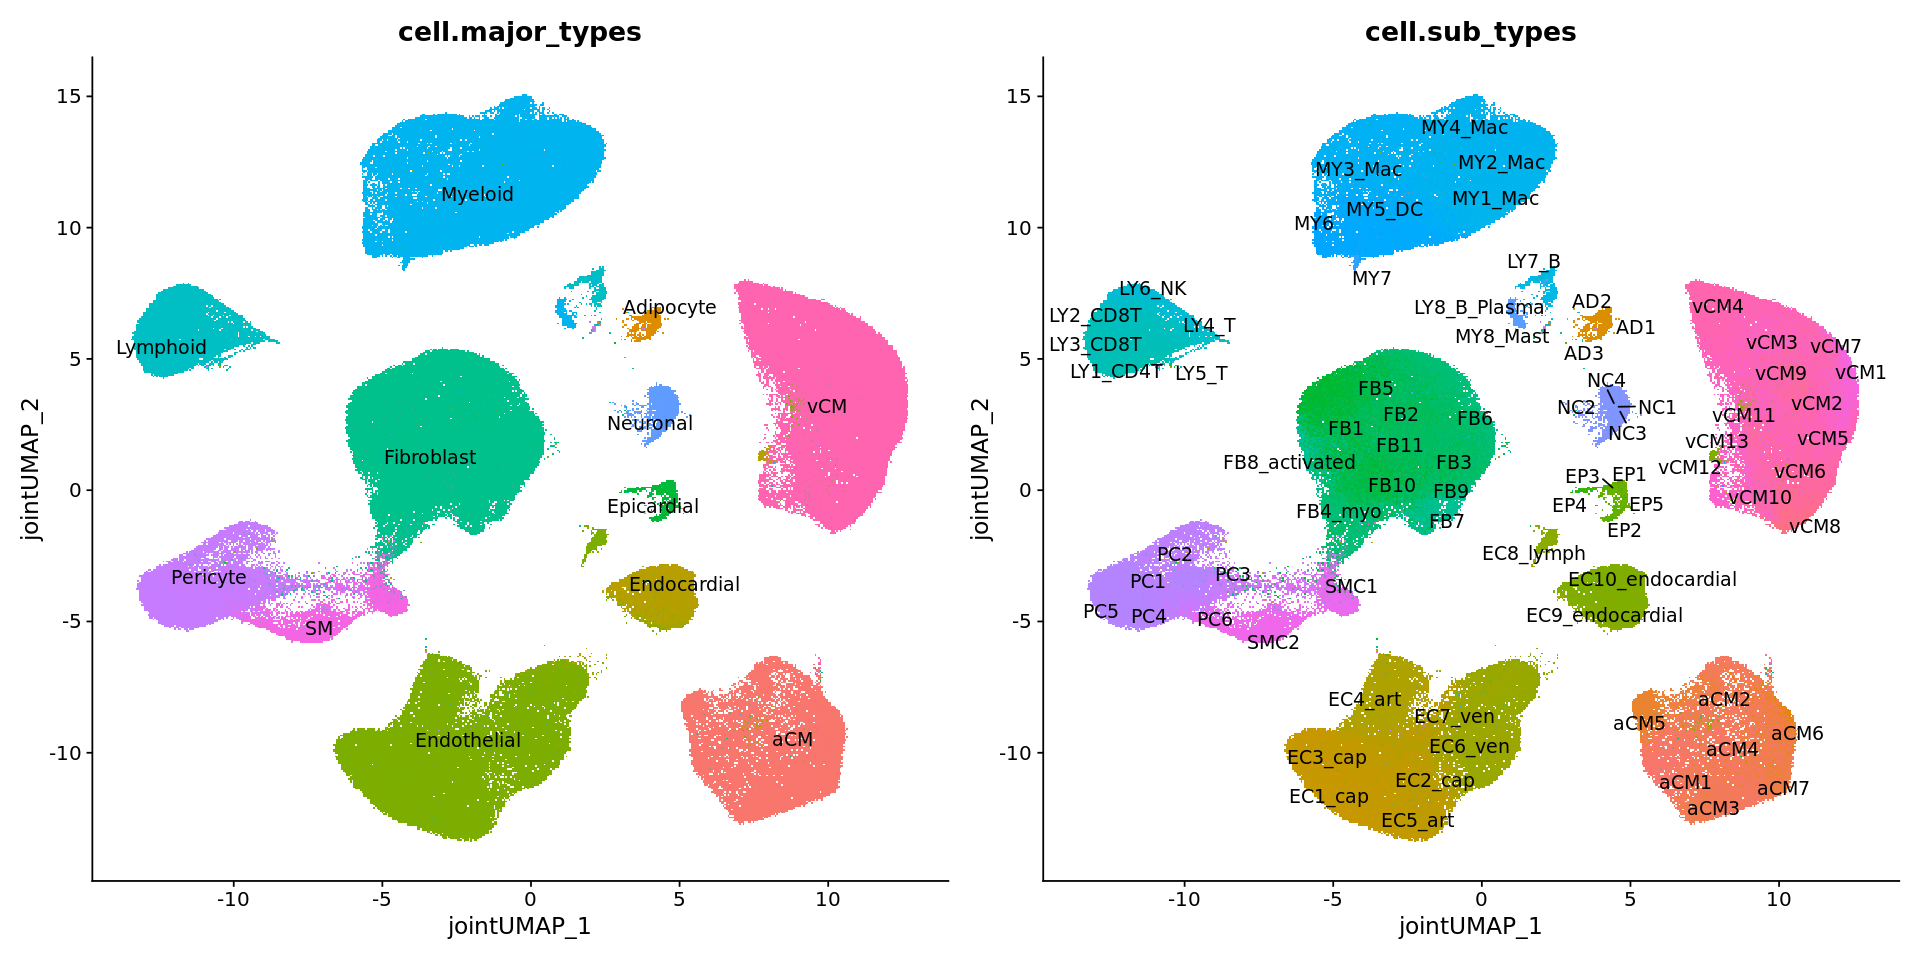

In [34]:
options(repr.plot.width=16, repr.plot.height=8)
gg1 + gg2

In [35]:
# Remove all cell-labels that's not these 2:
colnames(adata@meta.data)

[1] "orig.ident"                        "nCount_RNA"                       
 [3] "nFeature_RNA"                      "percent.mt"                       
 [5] "nCount_RNA_raw"                    "nFeature_RNA_raw"                 
 [7] "nCount_ATAC"                       "nFeature_ATAC"                    
 [9] "nCount_SCT"                        "nFeature_SCT"                     
[11] "SCT.weight"                        "ATAC.weight"                      
[13] "wsnn_res.0.2"                      "seurat_clusters"                  
[15] "log_nCount_ATAC"                   "log_nCount_SCT"                   
[17] "log_nFeature_ATAC"                 "log_nFeature_SCT"                 
[19] "wsnn_res.0.25"                     "library"                          
[21] "gex_raw_reads"                     "gex_mapped_reads"                 
[23] "gex_conf_intergenic_reads"         "gex_conf_exonic_reads"            
[25] "gex_conf_intronic_reads"           "gex_conf_exonic_unique_reads"     
[27] "gex_conf_exonic_antisense_reads"   "gex_conf_exonic_dup_reads"        
[29] "gex_exonic_umis"                   "gex_conf_intronic_unique_reads"   
[31] "gex_conf_intronic_antisense_reads" "gex_conf_intronic_dup_reads"      
[33] "gex_intronic_umis"                 "gex_conf_txomic_unique_reads"     
[35] "gex_umis_count"                    "gex_genes_count"                  
[37] "atac_raw_reads"                    "atac_unmapped_reads"              
[39] "atac_lowmapq"                      "atac_dup_reads"                   
[41] "atac_chimeric_reads"               "atac_mitochondrial_reads"         
[43] "atac_fragments"                    "atac_TSS_fragments"               
[45] "atac_peak_region_fragments"        "atac_peak_region_cutsites"        
[47] "donor"                             "chamber"                          
[49] "condition"                         "disease_status_major"             
[51] "disease_status_sub"                "diabetes_status"                  
[53] "age"                               "sex"                              
[55] "height"                            "weight"                           
[57] "BMI"                               "BMI.scaled"                       
[59] "weight.scaled"                     "height.scaled"                    
[61] "age.scaled"                        "TSS.enrichment"                   
[63] "TSS.percentile"                    "wsnn_res.0.5"                     
[65] "sil.qc"                            "cluster_sil.qc"                   
[67] "wsnn_res.0.6"                      "wsnn_res.1"                       
[69] "cell.major_types"                  "cell.sub_types"                   
[71] "cell.sub_types_disease"            "barcode"                          
[73] "gex_barcode"                       "atac_barcode"                     
[75] "is_cell"                           "excluded_reason"                  
[77] "chamber_major"                     "cell.sub_types_LUCA"              
[79] "cell.sub_types_chamber"            "cell.major_types_chamber"

In [41]:
# Test here columns:
unique(adata@meta.data$disease_status_major)
unique(adata@meta.data$disease_status_sub)
unique(adata@meta.data$condition)
unique(adata@meta.data$chamber)
unique(adata@meta.data$chamber_major)

unique(adata@meta.data$wsnn_res.0.25)

[1] "HF"     "NON_HF"

[1] "NICM_HF" "ICM_HF"  "NON_HF"

[1] "NICM_NDM" "ICM_NDM"  "CONTROL"  "NICM_DM"  "ICM_DM "

[1] "LV" "RV" "LA" "RA"

[1] "ventricle" "atria"

[1] 1  4  2  8  3  5  13 10 18 9  7  6  20 12 16 14 11 21 22 15 17 26 19 24 25
[26] 29 27 30 23
30 Levels: 1 10 11 12 13 14 15 16 17 18 19 2 20 21 22 23 24 25 26 27 28 ... 9

In [42]:
# Remove metadata we don't need
adata@meta.data$cell.major_types_chamber = NULL
adata@meta.data$cell.sub_types_chamber = NULL
adata@meta.data$cell.sub_types_LUCA = NULL
adata@meta.data$cell.sub_types_disease = NULL
adata@meta.data$cell.sub_types_LUCA = NULL
adata@meta.data$chamber_major = NULL
adata@meta.data$condition = NULL # We never used this metadata level, remove
adata@meta.data$wsnn_res.0.25 = NULL
adata@meta.data$wsnn_res.0.2 = NULL


# Make some metadata more intuitive
'all good'

[1] "all good"

In [43]:
colnames(adata@meta.data)

[1] "orig.ident"                        "nCount_RNA"                       
 [3] "nFeature_RNA"                      "percent.mt"                       
 [5] "nCount_RNA_raw"                    "nFeature_RNA_raw"                 
 [7] "nCount_ATAC"                       "nFeature_ATAC"                    
 [9] "nCount_SCT"                        "nFeature_SCT"                     
[11] "SCT.weight"                        "ATAC.weight"                      
[13] "seurat_clusters"                   "log_nCount_ATAC"                  
[15] "log_nCount_SCT"                    "log_nFeature_ATAC"                
[17] "log_nFeature_SCT"                  "library"                          
[19] "gex_raw_reads"                     "gex_mapped_reads"                 
[21] "gex_conf_intergenic_reads"         "gex_conf_exonic_reads"            
[23] "gex_conf_intronic_reads"           "gex_conf_exonic_unique_reads"     
[25] "gex_conf_exonic_antisense_reads"   "gex_conf_exonic_dup_reads"        
[27] "gex_exonic_umis"                   "gex_conf_intronic_unique_reads"   
[29] "gex_conf_intronic_antisense_reads" "gex_conf_intronic_dup_reads"      
[31] "gex_intronic_umis"                 "gex_conf_txomic_unique_reads"     
[33] "gex_umis_count"                    "gex_genes_count"                  
[35] "atac_raw_reads"                    "atac_unmapped_reads"              
[37] "atac_lowmapq"                      "atac_dup_reads"                   
[39] "atac_chimeric_reads"               "atac_mitochondrial_reads"         
[41] "atac_fragments"                    "atac_TSS_fragments"               
[43] "atac_peak_region_fragments"        "atac_peak_region_cutsites"        
[45] "donor"                             "chamber"                          
[47] "disease_status_major"              "disease_status_sub"               
[49] "diabetes_status"                   "age"                              
[51] "sex"                               "height"                           
[53] "weight"                            "BMI"                              
[55] "BMI.scaled"                        "weight.scaled"                    
[57] "height.scaled"                     "age.scaled"                       
[59] "TSS.enrichment"                    "TSS.percentile"                   
[61] "wsnn_res.0.5"                      "sil.qc"                           
[63] "cluster_sil.qc"                    "wsnn_res.0.6"                     
[65] "wsnn_res.1"                        "cell.major_types"                 
[67] "cell.sub_types"                    "barcode"                          
[69] "gex_barcode"                       "atac_barcode"                     
[71] "is_cell"                           "excluded_reason"

In [44]:
adata

An object of class Seurat 
392885 features across 329255 samples within 4 assays 
Active assay: ATAC (285873 features, 285873 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, RNA_raw, SCT
 8 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn, joint.umap

In [45]:
### Write  RDS
log_print("Saving RDS")
file = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.peaks.pub.rds"
saveRDS(adata, file = file)
log_print("RDS - Saved")

[1] "Saving RDS"
[1] "RDS - Saved"


In [ ]:
"name manually changed into: Multiomics_Reference.pub.rds"

In [102]:
out.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/reference/"
dir.create(out.dir)

In [103]:
# Get counts
counts_matrix <- GetAssayData(adata, assay = "ATAC", slot = "counts")

writeMM(counts_matrix,
        file = paste0(out.dir,
                      "ATAC_counts.mtx"))

write.table(rownames(counts_matrix),
        file = paste0(out.dir,
                      "ATAC_features.tsv"),
            sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)

# Write cell barcodes
write.table(colnames(counts_matrix),
        file = paste0(out.dir,
                      "Multiome_Barcodes.tsv"),
            sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)

NULL

In [ ]:
'moving manually to upload'